<h1 style="color:rgb(17, 116, 155);text-align:left;font-size:250%;font-family:verdana;text-decoration:underline;"> 
    Advanced topics - Final Project - Part 3: End-to-End CNN</h1>

## <u>שיפור ארכיטקטורת הרשת, Label Smoothing,אוגמנטציה מתקדמת </u>

## <u>Imports</u>

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from PIL import Image, ImageFilter
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import gc
from collections import defaultdict
import random
import matplotlib.pyplot as plt

In [5]:
# קביעת התקן (GPU אם קיים)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
torch.cuda.empty_cache()  # אם יש GPU 
gc.collect()  # ניקוי זיכרון בפייתון

208

## <u>Load and Preprocess Dataset</u>

In [8]:
# טעינת הנתונים (TFRecord) והכנה לפורמט PyTorch
print("Loading Cars196 dataset from TFRecord files...")

data_dir = r"C:\Users\yifat\Data Science\נושאים מתקדמים\Final_Project_Shay\cars196"

# יצירת רשימת קבצי ה-TFRecord
train_files = [os.path.join(data_dir, f"cars196-train.tfrecord-0000{i}-of-00008") for i in range(8)]
test_files = [os.path.join(data_dir, f"cars196-test.tfrecord-0000{i}-of-00008") for i in range(8)]

# פונקציה לקריאת TFRecord
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # מונע איבוד מידע
    image = tf.image.resize(image, (224, 224))

    label = parsed_example['label']
    return image, label


def load_tfrecord_dataset(filenames):
    raw_dataset = tf.data.TFRecordDataset(filenames)
    dataset = raw_dataset.map(parse_tfrecord)
    return list(dataset)  # ממירים לרשימה לשימוש ב-PyTorch

# טעינת ה-Train/Test מ-TFRecord
train_data = [(image, label) for image, label in load_tfrecord_dataset(train_files)]
test_data = [(image, label) for image, label in load_tfrecord_dataset(test_files)]

print(f"Loaded {len(train_data)} training images and {len(test_data)} test images.")


Loading Cars196 dataset from TFRecord files...
Loaded 8144 training images and 8041 test images.


In [9]:
# ביצוע דגימה אקראית מכל מחלקה ע"מ ליצור כמות דאטה קטנה יותר לצורכי בדיקת המודל והרצות מהירות יותר
# הדגימה תעשה ע"י ייצוג שיוויוני מכל מחלקה קיימת בדאטה-סט, כדי לוודא שכל הקטגוריות מיוצגות
# לצורך כך, אבחר 50% מהתמונות של כל מחלקה בנפרד, כדי שכל המחלקות יופיעו

In [10]:
# קביעת אחוז הדאטה לשימוש
subset_ratio = 0.5  # 50% מכל מחלקה

# ארגון הדאטה לפי מחלקות
class_to_images = defaultdict(list)
for image, label in train_data:
    class_to_images[label.numpy()].append((image, label))

# בחירת 50% מכל מחלקה
filtered_train_data = []
for label, images in class_to_images.items():
    num_samples = max(1, int(len(images) * subset_ratio))  # לוודא שיש לפחות תמונה אחת
    filtered_train_data.extend(random.sample(images, num_samples))

# חזרה על זה עבור הדאטה של הבדיקות
class_to_images_test = defaultdict(list)
for image, label in test_data:
    class_to_images_test[label.numpy()].append((image, label))

filtered_test_data = []
for label, images in class_to_images_test.items():
    num_samples = max(1, int(len(images) * subset_ratio))
    filtered_test_data.extend(random.sample(images, num_samples))

# עדכון הדאטה
train_data = filtered_train_data
test_data = filtered_test_data

print(f"Using {len(train_data)} training images and {len(test_data)} test images from all classes.")


Using 4021 training images and 3977 test images from all classes.


In [11]:
# מחלקת Dataset לטעינת הנתונים
class Cars196Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_tf, label = self.data[idx]  # image_tf הוא Tensor של TensorFlow
        image_np = image_tf.numpy()  # המרה ל-NumPy
        image = Image.fromarray((image_np * 255).astype(np.uint8))  # הבאת הפיקסלים לטווח 0-255
        if self.transform:
            image = self.transform(image)
        return image, label.numpy()  # גם label צריך להיות מספר ולא Tensor


In [12]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAutocontrast(p=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# סט הבדיקה ללא אוגמנטציה
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:
batch_size = 32
train_dataset = Cars196Dataset(train_data, transform=train_transform)
test_dataset = Cars196Dataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train and Test Dataloaders created with batch size {batch_size}.")
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


Train and Test Dataloaders created with batch size 32.
Training samples: 4021, Testing samples: 3977


In [14]:
# חישוב משקלים למחלקות לטיפול בחוסר איזון
labels_list = np.array([label.numpy() for _, label in train_data])  # המרה ל-NumPy
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_list), y=labels_list)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # המרה ל-Tensor של PyTorch


## <u>Define and Train a CNN Model</u>

In [16]:
# שיפור ארכיטקטורת הרשת – הוספת שכבות, נרמול ושכבות קונבולוציה נוספות
#######################################################
# הוספת שכבות Batch Normalization תייצב את הלמידה ותאפשר התכנסות טובה יותר.
# הוספת Conv+MaxPooling כפולות יאפשרו למודל ללמוד יותר פרמטרים תוך שמירה על יעילות חישובית.

In [17]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=196):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)  # שכבה נוספת
        self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(1024 * 7 * 7, 2048)  # התאמה לכמות הפיצ'רים החדשה
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # שכבה נוספת

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [18]:
print(torch.cuda.is_available())  # צריך להחזיר True
print(torch.cuda.device_count())  # צריך להיות 1 לפחות
print(torch.cuda.get_device_name(0))  # שם הכרטיס הגרפי

torch.cuda.empty_cache()  # אם יש GPU 
gc.collect()  # ניקוי זיכרון בפייתון

True
1
NVIDIA GeForce RTX 4050 Laptop GPU


543

In [19]:
# פונקציות אימון ובדיקה
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.to(device)
    running_loss = 0
    start_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()  # עדכון הלרנינג רייט בסוף כל אפוק
    end_time = time.time()
    running_loss /= len(train_loader)
    return running_loss, end_time - start_time
    

# פונקציה לבדיקה של המודל
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)
        running_loss = 0
        total_predictions = 0
        correct_predictions = 0
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
        running_loss /= len(test_loader)
        accuracy = (correct_predictions / total_predictions)*100.0
        return running_loss, accuracy


In [20]:
# שילוב Early Stopping 
######################

In [21]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        """
        patience - מספר האפוקים ללא שיפור לפני עצירה
        min_delta - השיפור המינימלי שייחשב לשיפור אמיתי
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # אפס את הספירה אם יש שיפור
        else:
            self.counter += 1  # ספירה של אפוקים ללא שיפור

        return self.counter >= self.patience  # עצור אם חרגנו ממספר האפוקים המותר


adamw_lr0003_decay1e5 | Epoch 1/50 | Train Loss: 5.5634 | Test Loss: 5.2692 | Test Acc: 0.93%
adamw_lr0003_decay1e5 | Epoch 2/50 | Train Loss: 5.3082 | Test Loss: 5.2538 | Test Acc: 0.80%
adamw_lr0003_decay1e5 | Epoch 3/50 | Train Loss: 5.2760 | Test Loss: 5.2422 | Test Acc: 0.85%
adamw_lr0003_decay1e5 | Epoch 4/50 | Train Loss: 5.2575 | Test Loss: 5.2228 | Test Acc: 1.11%
adamw_lr0003_decay1e5 | Epoch 5/50 | Train Loss: 5.2502 | Test Loss: 5.2345 | Test Acc: 0.60%
adamw_lr0003_decay1e5 | Epoch 6/50 | Train Loss: 5.2481 | Test Loss: 5.2204 | Test Acc: 1.18%
adamw_lr0003_decay1e5 | Epoch 7/50 | Train Loss: 5.2341 | Test Loss: 5.2206 | Test Acc: 1.11%
adamw_lr0003_decay1e5 | Epoch 8/50 | Train Loss: 5.2342 | Test Loss: 5.2137 | Test Acc: 0.75%
adamw_lr0003_decay1e5 | Epoch 9/50 | Train Loss: 5.2312 | Test Loss: 5.2272 | Test Acc: 0.93%
adamw_lr0003_decay1e5 | Epoch 10/50 | Train Loss: 5.2319 | Test Loss: 5.2147 | Test Acc: 0.98%
adamw_lr0003_decay1e5 | Epoch 11/50 | Train Loss: 5.2234 | 

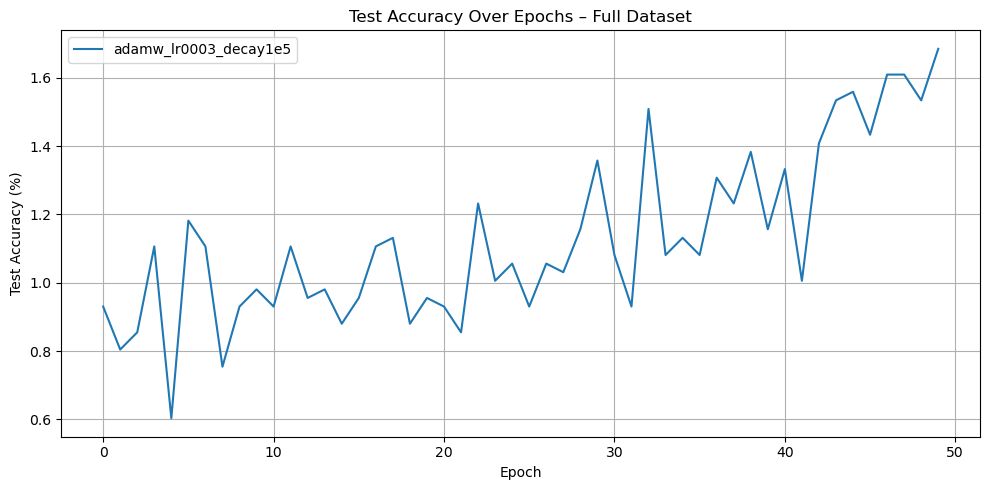

3193

In [22]:
num_epochs = 50  # הגדלת מספר האפוקים

# הגדרת הקונפיגורציה הנבחרת
chosen_config = {"name": "adamw_lr0003_decay1e5", "lr": 0.0003, "weight_decay": 1e-5}

# יצירת המודל והאופטימייזר
model = CNNClassifier(num_classes=196).to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=chosen_config["lr"],
    weight_decay=chosen_config["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005, steps_per_epoch=len(train_loader), epochs=num_epochs
)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

best_acc = 0.0
acc_per_epoch = []

for epoch in range(num_epochs):
    train_loss, train_time = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)

    print(f"{chosen_config['name']} | Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    best_acc = max(best_acc, test_acc)
    acc_per_epoch.append(test_acc)

    if early_stopping(test_loss):
        print(f"Early stopping for {chosen_config['name']} at epoch {epoch+1}\n")
        break

# שמירת המודל הסופי
#torch.save(model.state_dict(), f"model_{chosen_config['name']}_FULLDATA.pth")
#print(f"Model saved as model_{chosen_config['name']}_FULLDATA.pth")
torch.save(model.state_dict(), f"model_{chosen_config['name']}_50_DATA.pth")
print(f"Model saved as model_{chosen_config['name']}_50_DATA.pth")


# גרף תוצאת דיוק
plt.figure(figsize=(10, 5))
plt.plot(acc_per_epoch, label=chosen_config['name'])
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Over Epochs – Full Dataset")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ניקוי
del model
torch.cuda.empty_cache()
gc.collect()
